In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from environment import Environment

###################
# Q-FUNCTION GRID #
###################

def make_grid(img):
    line_color = (255,255,255)
    nboxes = 10
    bits_box = int(np.shape(img)[0]/nboxes)
    thickness = 10
    for x in range(1,10):
        point1 = (x*bits_box,0)
        point2 = (x*bits_box,np.shape(img)[0])
        img = cv2.line(img,point1,point2,line_color,thickness)
        img = cv2.line(img,(point1[1],point1[0]),(point2[1],point2[0]),line_color,thickness)
    return img

def create_states(pixel_box = 50*4,img_size = 500*4):
    states = {'tpos':[],'ppos':[],'predictions':{'N':[],'E':[],'S':[],'W':[]}, 'norm_preds':{'N':[],'E':[],'S':[],'W':[]}}
    for x in range(10):
        x_true_pos = 0.05 + 0.1*x
        x_pixel_pos = int(np.rint(x_true_pos*img_size))
        for y in range(10):
            y_true_pos = 0.05 + 0.1*y
            y_pixel_pos = int(np.rint(500*4 - y_true_pos*img_size))
            states['tpos'].append((x_true_pos,y_true_pos))

            tensor = torch.tensor([x_true_pos,y_true_pos])
            states_tensor = torch.unsqueeze(tensor,0)

            states['ppos'].append((x_pixel_pos,y_pixel_pos))
            preds = dqn.q_network.forward(states_tensor)[0]

            max_p = torch.max(preds).item()
            min_p = torch.min(preds).item()
            for i,direction in enumerate("N E S W".split()):
                states['predictions'][direction].append(preds[i].item())
                states['norm_preds'][direction].append((preds[i].item()-min_p)/(max_p-min_p))
    return states

# TUPLE CENTRE POINT (0.05,0.55)
def get_poly_points(centre_point):
    half_pixel_box = 25*4
    img_size = 500*4
    TL = (centre_point[0] - half_pixel_box, centre_point[1] - half_pixel_box)
    TR = (centre_point[0] + half_pixel_box, centre_point[1] - half_pixel_box)
    BL = (centre_point[0] - half_pixel_box, centre_point[1] + half_pixel_box)
    BR = (centre_point[0] + half_pixel_box, centre_point[1] + half_pixel_box)
    Np = np.array((TL,centre_point,TR))
    Ep = np.array((TR,centre_point,BR))
    Sp = np.array((BR,centre_point,BL))
    Wp = np.array((BL,centre_point,TL))
    return {'N':Np,'E':Ep,'S':Sp,'W':Wp}

def make_color(norm_preds):
    yellow = (255,255,0)
    blue = (0,0,255)
    color_diction = {}
    for i,key in enumerate('N E S W'.split()):
        color_diction[key] = np.add(np.multiply(norm_preds[i],yellow),np.multiply(1-norm_preds[i],blue)).astype(int)
    return color_diction

def run(dqn):
    bit_size = 2000
    img = np.zeros((bit_size,bit_size,3),dtype=np.uint8)
    img = make_grid(img)

    states = create_states(dqn)
    for cell in range(len(states['ppos'])):
        centre_point = states['ppos'][cell]
        poly_dict = get_poly_points(centre_point)

        norm_preds = [states['norm_preds'][direction][cell] for direction in 'N E S W'.split()]
        for i, move in enumerate('N E S W'.split()):
            direction = poly_dict[move]
            c = tuple([int(x) for x in make_color(norm_preds)[move]])
            cv2.fillConvexPoly(img,direction,color = c)
            cv2.polylines(img,[direction],False,color = (0,0,0), thickness = 5)

    img = make_grid(img)
    return img

###############
# GREEDY GRID #
###############

def draw_circle(img, bit_size, agent_state, agent_color):
    agent_centre = (int(agent_state[0] * bit_size), int((1 - agent_state[1]) * bit_size))
    agent_radius = int(0.03 * bit_size)
    cv2.circle(img, agent_centre, agent_radius, agent_color, cv2.FILLED)
    return 0

def find_color(step, max_steps):
    green = (0,255,0)
    red = (255,0,0)
    color = np.add(np.multiply(green,(step/max_steps)),np.multiply(red,(1-step/max_steps))).astype(int)
    c = tuple([int(x) for x in color])
    return c

def run_greedy(agent, dqn, bit_size = 2000, box_size = 200, total_steps = 13):
    
    gimg = np.zeros((bit_size,bit_size,3),dtype=np.uint8)
    gimg = make_grid(gimg)

    agent.reset()
    states = []
    # IT ACTUALLY TAKES 13 MOVEMENTS!!

    for step in range(total_steps):
        states.append(agent.epsilon_greedy_step(dqn)[0]) # only care about states

    draw_circle(gimg, 2000, states[0], (255,0,0))

    max_steps = len(states)-1
    for step, state in enumerate(states[:-1]):

        c = find_color(step,max_steps)

        x_pos_0 = int(np.rint(states[step][0]*bit_size))
        x_pos_1 = int(np.rint(states[step+1][0]*bit_size))

        y_pos_0 = int(np.rint(bit_size - states[step][1]*bit_size))
        y_pos_1 = int(np.rint(bit_size - states[step+1][1]*bit_size))

        cv2.line(gimg,(x_pos_0,y_pos_0),(x_pos_1,y_pos_1),c,thickness = 10)

    draw_circle(gimg, 2000, states[-1], (0,255,0))
    
    return gimg

In [104]:
# Import some modules from other libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import visualise
from environment import Environment

# The Agent class allows the agent to interact with the environment.
class Agent:

    # The class initialisation function.
    def __init__(self, environment,delta):
        # Set the agent's environment.
        self.environment = environment
        # Create the agent's current state
        self.state = None
        # Create the agent's total reward for the current episode.
        self.total_reward = None
        # Reset the agent.
        self.actions = np.arange(0,4) # discrete
        self.delta = delta
        self.epsilon = 1
        self.reset()

    # Function to reset the environment, and set the agent to its initial state. This should be done at the start of every episode.
    def reset(self):
        # Reset the environment for the start of the new episode, and set the agent's state to the initial state as defined by the environment.
        self.state = self.environment.reset()
        # Set the agent's total reward for this episode to zero.
        self.total_reward = 0.0
        # self.epsilon = 1 # IS IT THOUGH??

    # Function to make the agent take one step in the environment.
    def step(self):
        # Choose an action.
        discrete_action = np.random.choice(self.actions)
        # Convert the discrete action into a continuous action.
        continuous_action = self._discrete_action_to_continuous(discrete_action)
        # Take one step in the environment, using this continuous action, based on the agent's current state. This returns the next state, and the new distance to the goal from this new state. It also draws the environment, if display=True was set when creating the environment object..
        next_state, distance_to_goal = self.environment.step(self.state, continuous_action)
        # Compute the reward for this paction.
        reward = self._compute_reward(distance_to_goal,next_state)
        # Create a transition tuple for this step.
        transition = (self.state, discrete_action, reward, next_state)
        # Set the agent's state for the next step, as the next state from this step
        self.state = next_state
        # Update the agent's reward for this episode
        self.total_reward += reward
        # Return the transition
        return transition
    
    def decrease_epsilon(self):
        if self.epsilon < self.delta:
            pass
        else:
            self.epsilon -= self.delta
    
    def epsilon_pick(self,action_star):
        p = np.ones((4))*self.epsilon/4
        p[action_star] = 1 - self.epsilon + self.epsilon/4
        return np.random.choice([0,1,2,3],p = p)
    
    def epsilon_greedy_step(self,dqn,act_greedy = False):
        # FIND ARGMAX A from predicted Q(S,A)
        prediction = dqn.q_network.forward(torch.tensor(self.state))
        discrete_action_star = torch.argmax(prediction).item()
        
        # FIND DISCRETE ACTION FROM e-Greedy, when it is completely greedy, we pick epsilon star!
        if act_greedy == False: 
            discrete_action = self.epsilon_pick(discrete_action_star)
        else: 
            discrete_action = discrete_action_star
            
        continuous_action = self._discrete_action_to_continuous(discrete_action)
        next_state, distance_to_goal = self.environment.step(self.state, continuous_action)
        
        # Compute the Reward
        reward = self._compute_reward(distance_to_goal,next_state)
        
        # Find full transition
        transition = (self.state, discrete_action, reward, next_state)
        
        # Iterate
        self.state = next_state
        self.total_reward += reward
        self.decrease_epsilon() # Decrease epsilon by delta
        
        # For visualisation only, as when greedy we only care about next state (greedy in visualisation)
        return transition  

################
################
################
################

    # Function for the agent to compute its reward. In this example, the reward is based on the agent's distance to the goal after the agent takes an action.
    def _compute_reward(self, distance_to_goal, next_state):
        reward = (0.6 - distance_to_goal**1.4)# + 0.5*(1-distance_to_goal)**3
        if next_state is self.state:
            reward = - 0.2*distance_to_goal
        if distance_to_goal < 0.1:
            reward = 0.7
        return reward

################
################
################
################

    # Function to convert discrete action (as used by a DQN) to a continuous action (as used by the environment).
    def _discrete_action_to_continuous(self, discrete_action):
        discrete_action_array = self.move(discrete_action)
        continuous_action = np.array(discrete_action_array, dtype=np.float32)
        return continuous_action

    # Function to find all rewards for all actions at a given state...
    def _find_rewards(self,transition):
        rewards = np.zeros(np.size(self.actions))
        for index, action in enumerate(self.actions):
            continuous_action = self._discrete_action_to_continuous(action)
            _ , distance_to_goal = self.environment.step(self.state, continuous_action)
            rewards[index] = self._compute_reward(distance_to_goal)
        rewards = torch.unsqueeze(torch.tensor(rewards),0)
        return rewards

    def move(self, discrete_action):
        # Move function is a kind of dictionary that transforms actions into movements
        # 0 1 2 3 : N E S W
        step_size = 0.1
        if discrete_action == 0:
            return [0, step_size] # NORTH X_MOVEMENT, Y_MOVEMENT
        elif discrete_action == 1:
            return [step_size,0]
        elif discrete_action == 2:
            return [0,-step_size]
        elif discrete_action == 3:
            return [-step_size,0]
        return [0,0] # IF WRONG ACTION, just in case, do not move
    
    def __delete__(self):
        print('Deleted Agent')
        return None

# The Network class inherits the torch.nn.Module class, which represents a neural network.
class Network(torch.nn.Module):

    # The class initialisation function. This takes as arguments the dimension of the network's input (i.e. the dimension of the state), and the dimension of the network's output (i.e. the dimension of the action).
    def __init__(self, input_dimension, output_dimension):
        # Call the initialisation function of the parent class.
        super(Network, self).__init__()
        # Define the network layers. This example network has two hidden layers, each with 100 units.
        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=100)
        self.layer_2 = torch.nn.Linear(in_features=100, out_features=100)
        self.output_layer = torch.nn.Linear(in_features=100, out_features=output_dimension)

    # Function which sends some input data through the network and returns the network's output. In this example, a ReLU activation function is used for both hidden layers, but the output layer has no activation function (it is just a linear layer).
    def forward(self, input):
        layer_1_output = torch.nn.functional.relu(self.layer_1(input))
        layer_2_output = torch.nn.functional.relu(self.layer_2(layer_1_output))
        output = self.output_layer(layer_2_output)
        return output


# The DQN class determines how to train the above neural network.
class DQN:

    # The class initialisation function.
    def __init__(self):
        # Create a Q-network, which predicts the q-value for a particular state.
        self.q_network = Network(input_dimension=2, output_dimension=4)
        # Create a target Q-network for TD prediction
        self.target_q_network = Network(input_dimension=2, output_dimension=4)
        # Define the optimiser which is used when updating the Q-network. The learning rate determines how big each gradient step is during backpropagation.
        self.optimiser = torch.optim.Adam(self.q_network.parameters(), lr=0.001)
        self.train_counter = 0

    # Function that is called whenever we want to train the Q-network. Each call to this function takes in a transition tuple containing the data we use to update the Q-network.
    def train_q_network(self, batch, batch_size):
        # Once we have trained for 20 times, we update the target network!
        if self.train_counter%20 == 0:
            self.update_target_q_network()
        #self.update_target_q_network() # FOR WHEN WE USE NO TARGET Q NET
        
        # Set all the gradients stored in the optimiser to zero.
        self.optimiser.zero_grad()
        
        # Calculate the loss for this transition.
        loss = self._calculate_bellman_loss(batch, batch_size)
        
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        loss.backward()
        
        # Take one gradient step to update the Q-network.
        self.optimiser.step()
        
        # Iterate the training counter
        self.train_counter += 1
        
        # Return the loss as a scalar
        return loss.item()

    def update_target_q_network(self):
        dqn_dict =  torch.nn.Module.state_dict(self.q_network)
        torch.nn.Module.load_state_dict(self.target_q_network,dqn_dict)
        return 0 
    
    # Function to calculate the loss for a particular transition. No target or bellman equation used
    def _calculate_loss(self, batch, batch_size):

        states = np.array([batch[i][0] for i in range(batch_size)])
        rewards = np.array([batch[i][2] for i in range(batch_size)])
        actions = np.array([batch[i][1] for i in range(batch_size)])

        states_tensor = torch.tensor(states)
        rewards_tensor = torch.tensor(rewards)
        actions_tensor = torch.tensor(actions)

        # UNSQUEEZE ACTION, REWARD TENSORS TO Nx1
        action_tensor = torch.unsqueeze(actions_tensor.long(),1)
        rewards_tensor = torch.unsqueeze(rewards_tensor.float(),1)

        network_prediction = dqn.q_network.forward(states_tensor) # PREDICT FOR ALL ACTIONS
        predicted_Q = torch.gather(network_prediction,1,action_tensor) # ACTUAL Q FOR A GIVEN ACTION (OTHERS ARE REDUNDANT)
        loss = torch.nn.MSELoss()(predicted_Q,rewards_tensor)
        return loss
    
    def _calculate_bellman_loss(self, batch, batch_size):
        
        gamma = 0.9
        # gamma = 0
        
        states = np.array([batch[i][0] for i in range(batch_size)])
        actions = np.array([batch[i][1] for i in range(batch_size)])
        rewards = np.array([batch[i][2] for i in range(batch_size)])
        states_dash = np.array([batch[i][3] for i in range(batch_size)])

        states_tensor = torch.tensor(states)
        actions_tensor = torch.tensor(actions)
        rewards_tensor = torch.tensor(rewards)
        states_dash_tensor = torch.tensor(states_dash)

        # UNSQUEEZE ACTION, REWARD TENSORS TO Nx1
        action_tensor = torch.unsqueeze(actions_tensor.long(),1)
        rewards_tensor = torch.unsqueeze(rewards_tensor.float(),1)

        network_prediction = dqn.q_network.forward(states_tensor) # PREDICT FOR ALL actions the Q Values
        predicted_Q = torch.gather(network_prediction,1,action_tensor) # Q network prediction of Q at state
    
        target_network_prediction = dqn.target_q_network.forward(states_dash_tensor) # Successor state prediction from target network
        actions_dash_tensor = torch.argmax(target_network_prediction,dim = 1) # Best action at successor state tensor
        bellman_temp = torch.max(target_network_prediction,dim = 1)[0] # Q value predicted by network for successor state
        bellman_Q = rewards_tensor + torch.unsqueeze(bellman_temp,1)*gamma # R + gamma*Q

        bellman_loss = torch.nn.MSELoss()(predicted_Q,bellman_Q)
        
        return bellman_loss
    
    def __delete__(self):
        print('Deleted DQN')
        return None
        

class ReplayBuffer:

    def __init__(self,init_size = 1000000):
        self.deque = [None] * init_size
        self.init_size = init_size
        self.counter = 0 # variable used to count deque
        self.batch_counter = 0 # variable used for random suffling
        self.shuffled_index = 0 # index returning last element which was shuffled
        self.full_deque_sweeps = 0
        return None

    def collections_deque_append(self, transition):
        self.deque[self.counter] = transition
        self.counter += 1
        if self.counter == self.init_size:
            self.full_deque_sweeps += 1
            self.counter = 0
            print("Performed a full sweep, now we pop old values... Sweep {}".format(self.full_deque_sweeps))
        return 0

    def get_batch(self,batch_size):
        if self.counter < batch_size:
            raise Exception("Not enough data to train your batch")
        rand_indexes = np.random.randint(0,self.counter,batch_size)
        batch = [self.deque[rand_index] for rand_index in rand_indexes]
        return batch

    # wait until batch_size is smaller than counter
    def waiting_train(self,batch_size):
        if self.counter < batch_size:
            return True
        return False

    def shuffle(self):
        np.random.shuffle(self.deque)
        self.shuffled_index = self.counter
        return 0
    
# Main entry point
if __name__ == "__main__":

    # Set the random seed for both NumPy and Torch
    # You should leave this as 0, for consistency across different runs (Deep Reinforcement Learning is highly sensitive to different random seeds, so keeping this the same throughout will help you debug your code).
    CID = 66209
    np.random.seed(CID)
    torch.manual_seed(CID)
    
    # Create an environment.
    environment = Environment(display=False, magnification=500)
    # If display is True, then the environment will be displayed after every agent step. This can be set to False to speed up training time. The evaluation in part 2 of the coursework will be done based on the time with display=False.
    # Magnification determines how big the window will be when displaying the environment on your monitor. For desktop PCs, a value of 1000 should be about right. For laptops, a value of 500 should be about right. Note that this value does not affect the underlying state space or the learning, just the visualisation of the environment.
    #environment = Environment(display=False, magnification=500)
    
    # Create an agent
    delta = 0.004
    agent = Agent(environment, delta = delta) #1e-3
    
    # Create a DQN (Deep Q-Network)
    dqn = DQN()
    
    # Create deque class
    buffer = ReplayBuffer(init_size = 1000000)

    # Loop over episodes
    loss_arr = []
    final_dist_arr = []
    step_arr = []
    episode = 0
    episodes = 25
    batch_size = 50

    while episode < episodes:
        # Reset the environment for the start of the episode.
        agent.reset()
        # Loop over steps within this episode. The episode length here is 1000.
        for step_num in range(20):
            # Step the agent once, and get the transition tuple for this step

            transition = agent.epsilon_greedy_step(dqn)
            #transition = agent.step()

            buffer.collections_deque_append(transition)
            if buffer.waiting_train(batch_size=batch_size):
                loss_arr.append(0)
                continue
                
            batch = buffer.get_batch(batch_size=batch_size)
            loss = dqn.train_q_network(batch, batch_size)
            loss_arr.append(loss)
            
            _, TR, final_distance = visualise.run_greedy(agent,dqn,total_steps = 20)
            final_dist_arr.append(final_distance[-1])
            step_arr.append(step_num + episode*20)
            
        episode += 1        
        
    #img = visualise.run(dqn)
    #plt.figure()
    #plt.imshow(img)
    #plt.show()
    
    #gimg = visualise.run_greedy(agent,dqn,total_steps = 13)
    #plt.figure()
    #plt.imshow(gimg)
    #plt.show()

Text(0, 0.5, 'Distance to Goal')

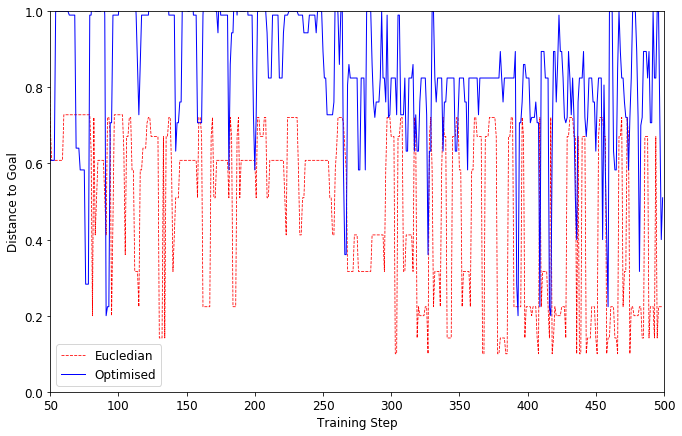

In [105]:
dtg['Optimised'] = final_dist_arr

plt.figure(figsize=(11,7))
styles = 'g- b- r-- k-- y--'.split()

plt.plot(step_arr,dtg['Eucledian'], styles[2], label = 'Eucledian',linewidth = 0.8, marker = 'o',markersize = 0)
plt.plot(step_arr,dtg['Optimised'], styles[1], label = 'Optimised',linewidth = 1,marker = 'o',markersize = 0)
#plt.plot(step_arr,dtg['SQRT'], styles[0], label = 'SQRT',linewidth = 2)

plt.legend()
plt.xlim([50, 500])
plt.ylim([0, 1])
plt.xlabel('Training Step')
plt.ylabel('Distance to Goal')
#plt.savefig('Figure5_optimised_step' + '.eps', bbox_inches = "tight")

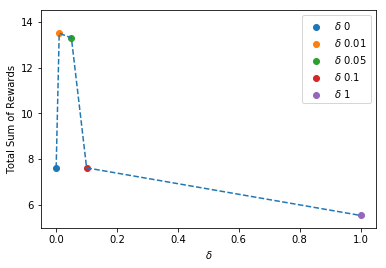

In [529]:
final_rewards = [7.6219,13.5,13.3,7.62,5.54]
delta_list = [0,0.01,0.05,0.1,1]
plt.figure()
plt.plot(delta_list,final_rewards,'--')
#plt.scatter(0.00001,final_rewards[0],label = '$\delta$ 0')
for i in range(len(final_rewards)):
    plt.scatter(delta_list[i],final_rewards[i],label = '$\delta$ {}'.format(delta_list[i]))
plt.ylim([5, 14.5])
plt.xlim([-0.05,1.05])
plt.xlabel('$\delta$')
plt.ylabel('Total Sum of Rewards')
plt.legend()
plt.savefig('Figure4_ffff' + '.eps', bbox_inches = "tight")

In [671]:
agent.environment.goal_state

array([0.75, 0.85], dtype=float32)

In [9]:
# dtg = {}

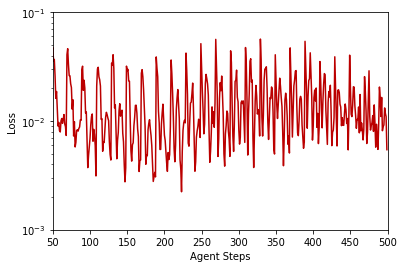

In [730]:
plt.figure()
plt.plot(loss_arr,'-',color = '#bb0000',linewidth = 1.5) 
plt.xlabel('Agent Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.xlim([50,500])
plt.ylim([0.001,0.1])
plt.savefig('Figure3b' + '.eps', bbox_inches = "tight")

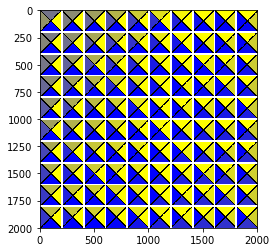

In [530]:
img = visualise.run(dqn)
plt.figure()
plt.imshow(img)
plt.show()

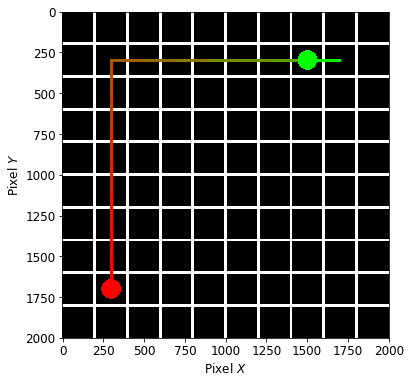

In [103]:
plt.figure(figsize=(6,6))
gimg,_,_ = visualise.run_greedy(agent,dqn,total_steps = 20)
plt.imshow(gimg)
plt.xlabel('Pixel $X$')
plt.ylabel('Pixel $Y$')
plt.savefig('Figure5b_optimised' + '.eps', bbox_inches = "tight")

In [131]:
%matplotlib inline

In [67]:
# gimg, TR, _ = visualise.run_greedy(agent,dqn,total_steps = 21)
# rewards_delta['$\delta$ {}'.format(delta)] = TR
# plt.figure()
# styles = 'g- b-- y-- k-- r-'.split()
# index = 0
# for delta_key, rewards in rewards_delta.items():
#     print(delta_key, np.shape(rewards))
#     plt.plot(rewards, styles[index], label = delta_key,linewidth = 2.5)
#     index += 1
# index = 0
# plt.legend()
# plt.xlim([-0.5, 20.5])
# plt.ylim([-0.5, 14.5])
# plt.xlabel('Agent Step')
# plt.ylabel('Total Sum of Rewards')

In [102]:
plt.rcParams.update({'font.size': 12})

In [52]:
%matplotlib qt